In [23]:
from atmospheric_explorer.cams_interfaces import EAC4Instance, InversionOptimisedGreenhouseGas
from atmospheric_explorer.shapefile import ShapefilesDownloader
from atmospheric_explorer.utils import get_local_folder
from atmospheric_explorer.units_conversion import convert_units_array
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import cdsapi
import os
import zipfile
from glob import glob
import xarray as xr
from datetime import datetime
import geopandas as gdp
from shapely.geometry import mapping
import rioxarray as rio

In [24]:
#function to move from 0+360 to -180+180 long
def ds_swaplon(ds):
    return ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

In [3]:
c = cdsapi.Client()

c.retrieve(
    'cams-global-greenhouse-gas-inversion',
    {
        'version': 'latest',
        'format': 'zip',
        'variable': 'carbon_dioxide',
        'quantity': 'surface_flux',
        'input_observations': 'surface',
        'time_aggregation': 'monthly_mean',
        'year': [
            '1982', '1983', '1984',
            '1985', '1986', '1987',
            '1988', '1989', '1990',
            '1991', '1992', '1993',
            '1994', '1995', '1996',
            '1997', '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
            '2021',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12'
        ],
    },
    'CO2flux.zip')

KeyboardInterrupt: 

In [ ]:
with zipfile.ZipFile('CO2flux.zip', "r") as zip_ref:
    zip_ref.extractall('./CO2flux')

In [27]:
df = xr.open_dataset('/mnt/c/Users/LuigiBrancati/Documents/ECMWF/atmospheric-explorer/atmospheric_explorer/CO2flux/cams73_latest_co2_flux_surface_mm_198201.nc')[['flux_foss']]
df = df.expand_dims({'time': [datetime.strptime('198201', '%Y%m')]})
for file in glob('./CO2flux/*')[1:]:
    mm = datetime.strptime(file.split('_')[-1].split('.')[0], '%Y%m')
    temp = xr.open_dataset(file)[['flux_foss']]
    temp = temp.expand_dims({'time': [mm]})
    df = xr.combine_by_coords([df, temp])
df = df.rio.write_crs('EPSG:4326')

In [28]:
# df = ds_swaplon(df)

In [29]:
df

<xarray.Dataset>
Dimensions:      (time: 480, latitude: 96, longitude: 96)
Coordinates:
  * time         (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2021-12-01
  * longitude    (longitude) float64 -180.0 -176.2 -172.5 ... 168.8 172.5 176.2
  * latitude     (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
    spatial_ref  int64 0
Data variables:
    flux_foss    (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    title:        Global surface fluxes inferred by atmospheric inversion
    institution:  LSCE (CEA/CNRS/UVSQ) - IPSL
    source:       Assimilation of surface air-sample measurements
    history:      2022-07-19 19:53:47 GMT, PYVAR run by p24cheva
    references:   Chevallier et al. (JGR, 2005, JGR, 2010, ACP, 2019)
    comment:      Positive fluxes release carbon to the atmosphere

In [31]:
sh = gdp.read_file('./italy_shapefile/ne_10m_admin_0_countries_ita.shp', crs='EPSG:4326')

,ADM0_A3_IT,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
88,ITA,Admin-0 country,0,2,Italy,ITA,0,2,Sovereign country,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((7.02208 45.92526, 7.06694 45.8..."


In [83]:
df_clipped = df.rio.clip(sh[sh['ADMIN'] == 'Italy'].geometry.apply(mapping), sh.crs, drop=True)['flux_foss']

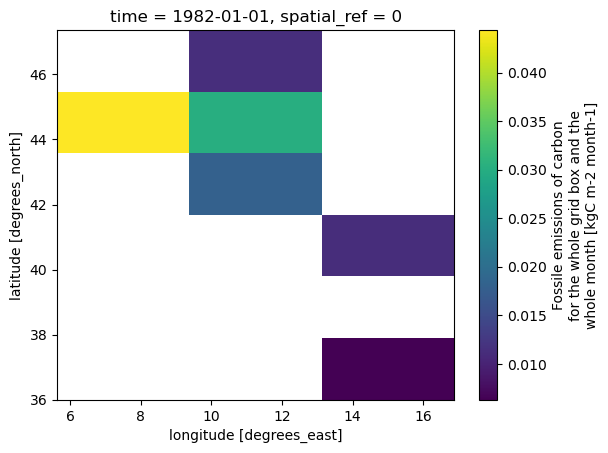

In [84]:
df_clipped[0].plot()

In [85]:
df_clipped = df_clipped.where(~df_clipped.isnull(), drop=True)

In [86]:
df_clipped = df_clipped.sortby('time').mean(dim=['longitude', 'latitude'])

In [93]:
df_clipped.coords['time.year']

<xarray.DataArray 'year' (time: 480)>
array([1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982,
       1982, 1983, 1983, 1983, 1983, 1983, 1983, 1983, 1983, 1983, 1983,
       1983, 1983, 1984, 1984, 1984, 1984, 1984, 1984, 1984, 1984, 1984,
       1984, 1984, 1984, 1985, 1985, 1985, 1985, 1985, 1985, 1985, 1985,
       1985, 1985, 1985, 1985, 1986, 1986, 1986, 1986, 1986, 1986, 1986,
       1986, 1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1987, 1987,
       1987, 1987, 1987, 1987, 1987, 1987, 1988, 1988, 1988, 1988, 1988,
       1988, 1988, 1988, 1988, 1988, 1988, 1988, 1989, 1989, 1989, 1989,
       1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1990, 1990, 1990,
       1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1991, 1991,
       1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1992,
       1992, 1992, 1992, 1992, 1992, 1992, 1992, 1992, 1992, 1992, 1992,
       1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993,
       1993, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994,
       1994, 1994, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
       1995, 1995, 1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
       1996, 1996, 1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
       1997, 1997, 1997, 1997, 1997, 1998, 1998, 1998, 1998, 1998, 1998,
       1998, 1998, 1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 1999,
       1999, 1999, 1999, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000,
...
       2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004,
       2004, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005,
       2005, 2005, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006,
       2006, 2006, 2006, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007,
       2007, 2007, 2007, 2007, 2008, 2008, 2008, 2008, 2008, 2008, 2008,
       2008, 2008, 2008, 2008, 2008, 2009, 2009, 2009, 2009, 2009, 2009,
       2009, 2009, 2009, 2009, 2009, 2009, 2010, 2010, 2010, 2010, 2010,
       2010, 2010, 2010, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011,
       2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2012, 2012, 2012,
       2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2013, 2013,
       2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2014,
       2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
       2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
       2015, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
       2016, 2016, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
       2017, 2017, 2017, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
       2018, 2018, 2018, 2018, 2019, 2019, 2019, 2019, 2019, 2019, 2019,
       2019, 2019, 2019, 2019, 2019, 2020, 2020, 2020, 2020, 2020, 2020,
       2020, 2020, 2020, 2020, 2020, 2020, 2021, 2021, 2021, 2021, 2021,
       2021, 2021, 2021, 2021, 2021, 2021, 2021])
Coordinates:
  * time         (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2021-12-01
    spatial_ref  int64 0

In [101]:
import plotly.graph_objects as go

In [102]:
fig = go.Figure()

In [104]:
fig.add_trace(
    go.Scatter(
        y=df_clipped.values,
        x=df_clipped.coords['time.year'],
        mode='lines'
    )
)

In [30]:
# TODO:
## 1 - Shiftare lat e long se necessario -> EAC4 va da 0 a 360
## 2 - Clip paese -> Capire se funziona, dovrebbe funzionare
## 3 - Media annuale -> In realtà ci dovrebbe essere un modo per calcolare il CI su plotly, basta avere diversi valori per anno
## 4 - Plot con CI al 95%

## 5 - le api per scaricare i dati cams e lo shapefile non sembrano funzionare
## 6 - Sistemare il grafico in modo da farlo più simile